生成模型如GPT-2、3最令人震惊的是它可以在没有明确的监督情况下生成。仅仅是通过从上千个网页的文本数据预测下一个单词，它们就可以学习到多种多样的模式识别能力，这些能力可以通过不同的提示词（Prompts）来激活。下图展示了一个语言模型在预训练过程中被输入了不同的任务序列，在这些任务序列中，它们需要仅根据上下文预测接下来的token，如加法、辨析单词和翻译。这些使得他们可以在微调（fine-tuning）或推断时有效的转移这些知识。这些任务不是提前选择的，而是用于训练十亿参数语言模型的庞大语料库中自然发生的。
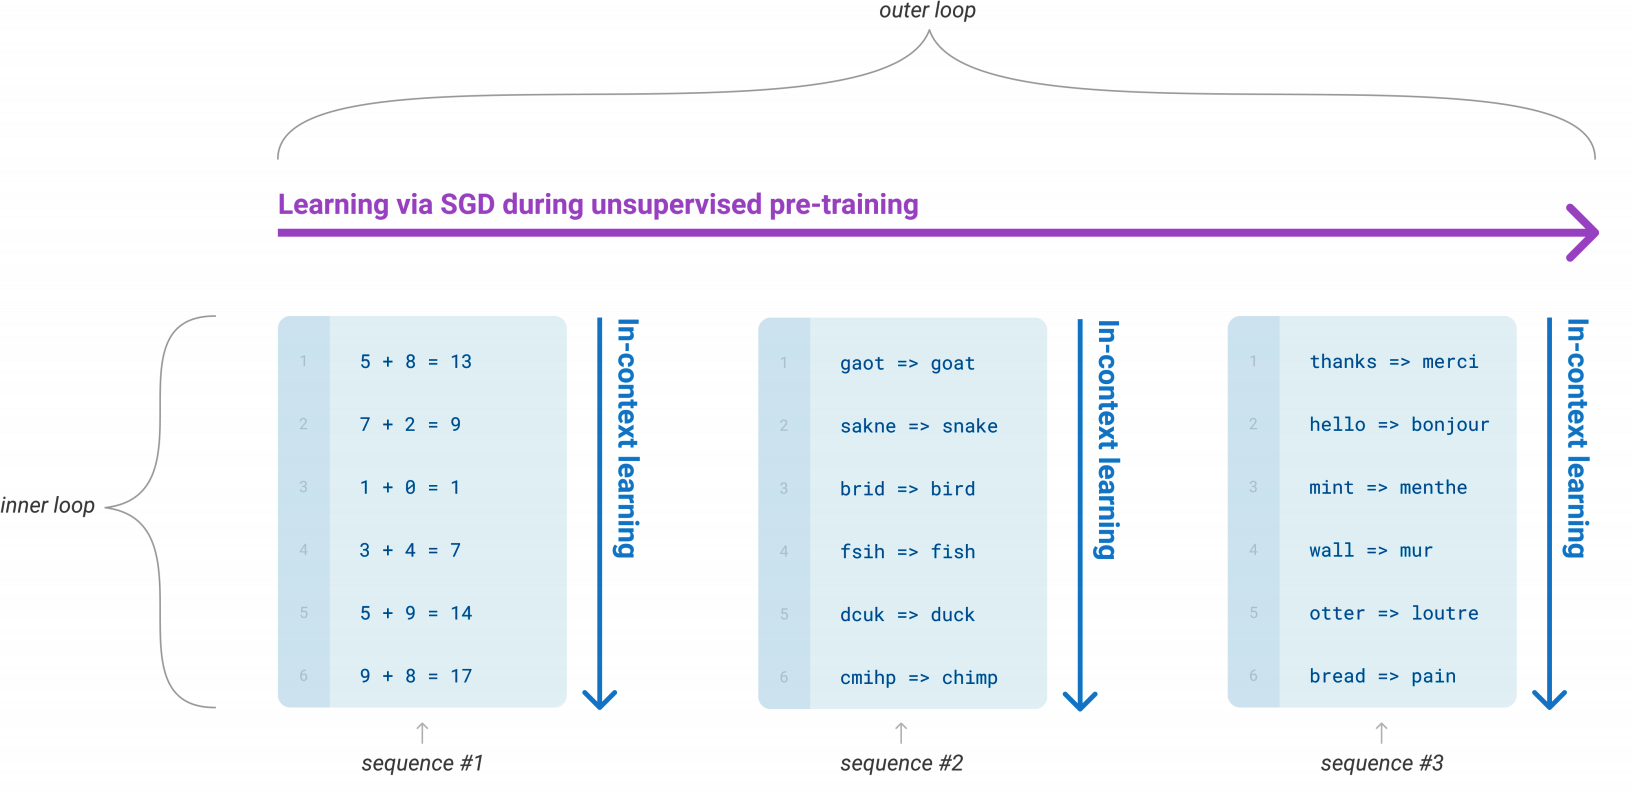

本章我们将用GPT-2阐述一个语言模型是如何生成文本的，并展示不同的decoding策略怎样影响文本生成。  
[GPT-2源码解读](https://medium.com/analytics-vidhya/understanding-the-gpt-2-source-code-part-5-87bbe21dd749#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6Ijk4NmVlOWEzYjc1MjBiNDk0ZGY1NGZlMzJlM2U1YzRjYTY4NWM4OWQiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NzkyODM4NzEsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExNDQ3OTk4NzU1MjA5NTcwNDA5MiIsImVtYWlsIjoiMjYzODEyMzQyM3dhbmdAZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImF6cCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsIm5hbWUiOiJ4dWFuIHdhbmciLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUdObXl4Yjc5LVFrOUFjODNINjNpQXlsMGNKS3dqY1VTWnlMWFpXWGdOWnE9czk2LWMiLCJnaXZlbl9uYW1lIjoieHVhbiIsImZhbWlseV9uYW1lIjoid2FuZyIsImlhdCI6MTY3OTI4NDE3MSwiZXhwIjoxNjc5Mjg3NzcxLCJqdGkiOiJhYjIzM2VlYTllNjk3MTIyM2FiOGE5Njc1MGUxNmEyMGJhMzZiNTQ0In0.T5Ea0nxyL0YW06-oXvQdkU6n1kplR-9nEZ0sFUQ_ZB_8FA3YQ8sNB2-E2rG3TAPyVY_zbV4YB2iEM37MPFZAf9fq5xiPWMPhzQJtylnd9Prc8LQUM8xZZTXdD-vNdYEKmDyowBKDXQFgVHTZXFOrrjoIW93NfX0i5Ng7kiIAoxRTn9ey7ZRtghQYyItegdh7ajFvQuQNF3ryk4JUeVpiCVNLUl8rDAEuyTHRnkILXSMQhn9VPGy_ElCRTIL7e-uS5EkL5BHC5KFyx2HjuNZUjZP9C_q2KaG1LlMPPKTHzuvDIXNSpQjjhgw_Kj2DDj4onRKbv2UoJl7COI1srXZK6w)

# The Challenge with Generating Coherent Text

到目前为止，我们都是专注于一类结合预训练和有监督的微调（fine-tuning）的NLP任务。正如我们看到的，对于某个特定任务的模型头部如序列或是token分类问题，生成预测时非常直观的。**模型产出一些logits(a linear layer that maps the output of the transformer to a vector with a dimension equal to the size of the vocabulary,单指全连接层的输出)，我们要么取得最大值作为预测的类别（最大/对数最大似然估计），要么应用softmax函数来获得每个类别的预测概率**。相比之下，将模型的概率输出转化为文本需要一种*decoding method*，这回带来一些文本生成独有的挑战。
1. decoding是迭代完成的，因此与简单地通过模型的前向传递将输入一次性传入相比，涉及的计算量多很多
2. 文本生成的质量和多样性取决于解码方法以及相关的超参数。

为了理解这个decoding过程是如何起作用的，我们从研究GPT-2是怎样预训练以及接下来如何应用生成文本开始。  
如很多其他的自回归或者因果语言模型一样，GPT-2被预训练来评估一系列在文本中出现的token $\boldsymbol{y} = y_1, y_2,...y_t$的概率$P(\boldsymbol{y}|\boldsymbol{x})$，这里已经给出了一些初始的提示词或者上选文序列$x = x_1, x_2, ...x_k$。因为通过获取足够的序列数据去直接预估$P(\boldsymbol{y}|\boldsymbol{x})$是不切实际的，所以利用概率的链式法则去将其分化为条件概率的乘积是非常常见的办法。  
$P(y_1,...,y_t|\boldsymbol{x}) = \prod_{t = 1}^NP(y_t|y_{<t},\boldsymbol{x})$  
只用前序词来预测之后的单词这种方式与autoregression几乎完全一致。我们可以看到这种预训练的目标是与BERT这种从前后文来一起预测masked token的方式是非常不一样的。以下是给出提示词序列“Transformers are the”之后的预测过程
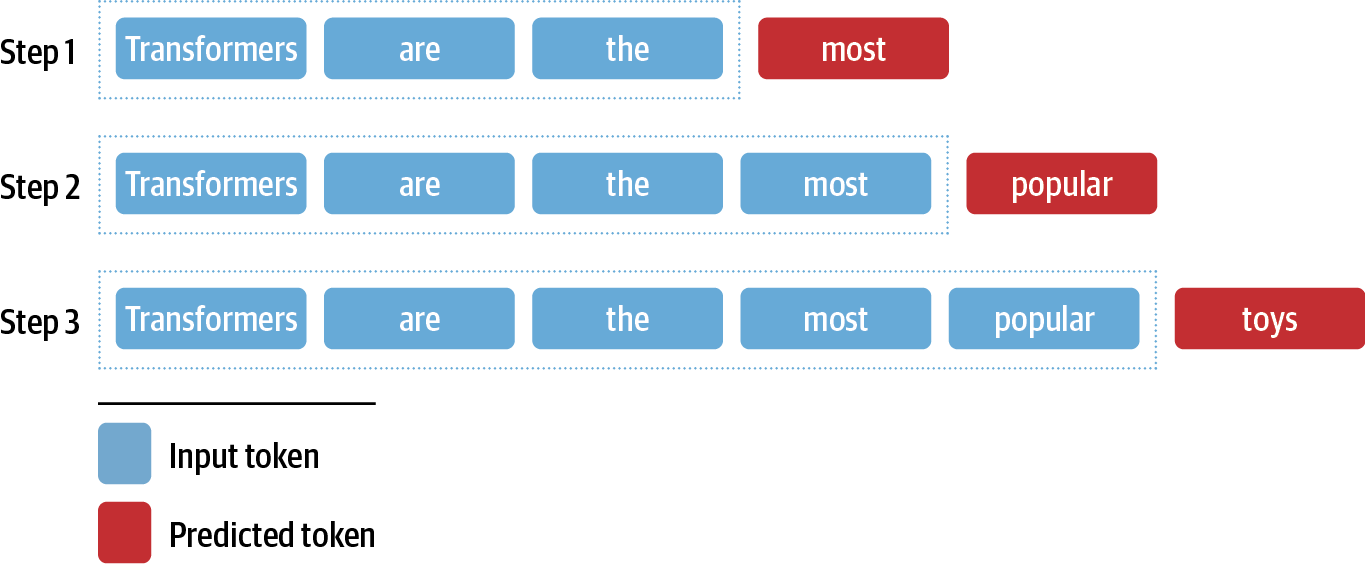

这一过程的核心步骤取决于decoding方法，它会决定在每一个时间节点哪个token被选出来。因为语言模型的head会在每一步产生一个$logit z_{t,i}$，我们可以通过softmax函数获得下一个token $w_i$的概率分布  
$P(y_t = w_i|y_{<t},\boldsymbol{x}) = softmax(z_{t,i})$  
大多数的decoding方法是去寻找最可能出现的整体序列，也即找到一个 $\boldsymbol{\hat{y}}$  
$\boldsymbol{\hat{y}} = \mathop{\arg\max}\limits_{y} P(\boldsymbol{y}|\boldsymbol{x})$  
我们会选用一个近似的方法来选择$\boldsymbol{\hat{y}}$，因为直接搜寻在合理时间内是无法完成这个操作的。本章中我们会探索一些近似的方法，并逐渐建立起可用于生成高质量文本的更智能、更复杂的算法。

# Greedy Search Decoding
最直观的方法就是贪心算法，也即每一步都选择当前步骤下最大概率的token  
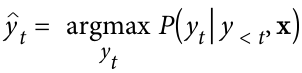

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,return_dict=True).to(device)

虽然Transformers对于像GPT-2这种自回归模型设计了generate()函数来，但是我们会自己完成一遍decoding method来看一下它是如何工作的。我们会用“Transformers are the”作为输入提示词然后迭代decoding八次。在每个时间步，我们为提示中的最后一个标记选择模型的对数，并用 softmax 将它们包装起来以获得概率分布。接下来我们选择概率最大的作为下一个token，将其添加到输入序列中，再次跑这个过程。以下代码就是执行了这个工作，并且每次也存储了五个最可能的token，以便我们可以可视化备选方案。

In [4]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids = input_ids)
        # select logits of the first batch and the last token and apply softmax
        #这里必须要是第一个batch的原因是，只有一个batch
        next_token_logits = output.logits[0,-1,:]
        next_token_probs = torch.softmax(next_token_logits, dim = -1)
        sorted_ids = torch.argsort(next_token_probs, dim = -1, descending = True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)}({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim = -1)
        iterations.append(iteration)

pd.DataFrame(iterations)


,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most(9.76%),same(2.94%),only(2.87%),best(2.38%),first(1.77%)
1,Transformers are the most,common(22.90%),powerful(6.88%),important(6.32%),popular(3.95%),commonly(2.14%)
2,Transformers are the most common,type(15.06%),types(3.31%),form(1.91%),way(1.89%),and(1.49%)
3,Transformers are the most common type,of(83.13%),in(3.16%),.(1.92%),",(1.63%)",for(0.88%)
4,Transformers are the most common type of,particle(1.55%),object(1.02%),light(0.71%),energy(0.67%),objects(0.66%)
5,Transformers are the most common type of particle,.(14.26%),in(11.57%),that(10.19%),",(9.57%)",accelerator(5.81%)
6,Transformers are the most common type of parti...,They(17.48%),\n(15.19%),The(7.06%),These(3.09%),In(3.07%)
7,Transformers are the most common type of parti...,are(38.78%),have(8.14%),can(7.98%),'re(5.04%),consist(1.57%)


教材中生成的是“Transformers are the most popular toy line in the world”，这里我们生成的是。“Transformers are the most common type of particle. They are” 有趣的是，原文中生成的后序文本表明 GPT-2 已经内化了一些关于变形金刚媒体专营权的知识，该专营权由两家玩具公司（Hasbro和 Takara Tomy）创建。  
实现greddy search并不是很困难，但是我们想要利用Transformers内建的generate()函数来探索更加复杂的decoding方法。为了复现我们的例子，让我们确保采样是关闭的（他默认就是关闭的，除非您要从其他状态加载checkpoint的模型的特定配置），另外明确max_new_tokens来规定新生成tokens的数量

In [33]:
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
output = model.generate(input_ids, max_length = n_steps, do_sample = False)

print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
    


In [28]:
# 让我们尝试从OpenAI重现独角兽的故事
max_length = 100
input_txt = """In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\n   
    """

input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
output_greedy = model.generate(input_ids, max_length = max_length,eos_token_id=model.config.eos_token_id,
                               do_sample = False)
print(tokenizer.decode(output_greedy[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
                                             


greedy search decoding最大的问题：  
他倾向于产出重复的序列，这不是我们在新的文本中想要看到的。当然这是greedy search算法的常见问题，即很难给出你最优的结果。在上下文decoding中，他们可能会错过总体概率较高的单词序列，因为高概率单词恰好位于低概率单词之前。幸运的是我们可以通过Beasm Search Decoding来改善这个结果。                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Beam Search Decoding

不是用每步概率最高的token作为输出。beam search选择用top-b最大可能的token，其中 b 指的是beam或部分假设的数量。 通过考虑现有集合的所有可能的下一个标记扩展并选择最有可能的 b 来选择下一组波束
扩展。这一过程会一直重复直到我们达到了最大的长度或者EOS token，然后最大可能性的序列会被选出来然后根据b beams的log 概率进行排序。具体beam search的例子如下
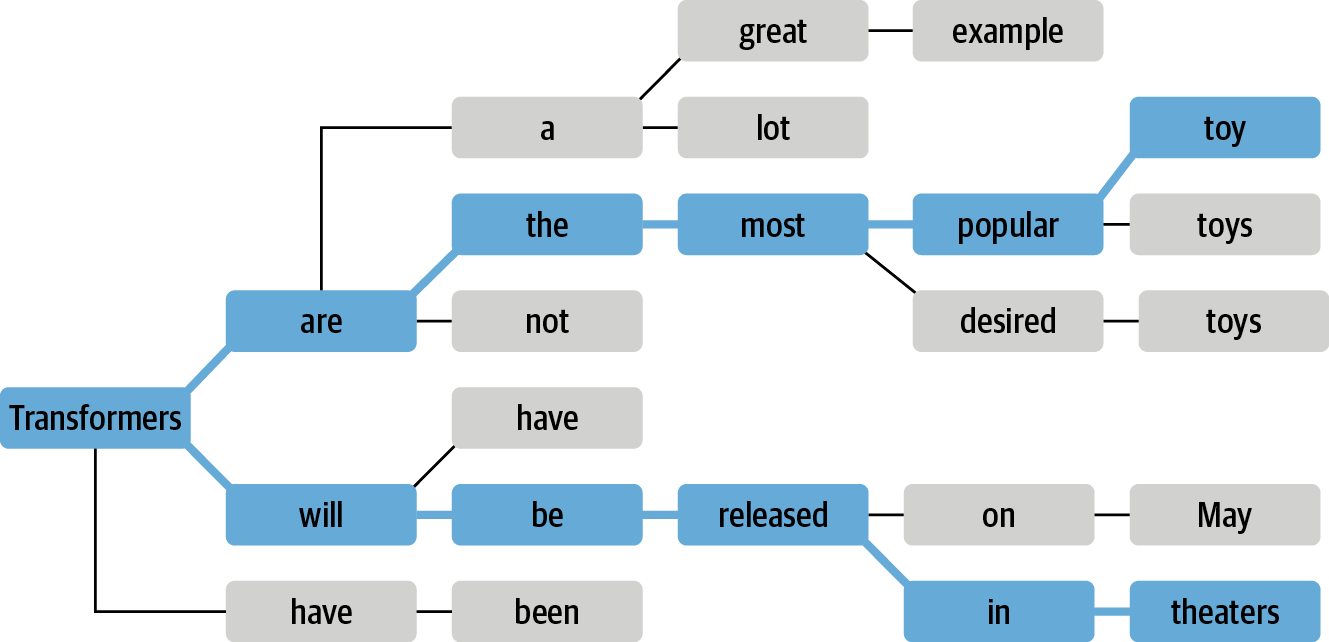

使用对数概率的主要原因是，在计算全概率时$P(y_1,y_2,...y_t|x)$需要通过条件概率$P(y_t|y_{<t}, x)$乘积而得。这会让全概率小到下溢出计算机的计算精度。而使用对数概率可以把乘积变为加法，利于计算  
因为Transformers模型返回的是根据输入给出的下一个token非归一化的logits， 我们第一步是要对logits做归一化进而为序列中每个token做一个概率分布，然后我们只需要选择序列中出现的标记概率。 以下函数实现了这些步骤：

In [9]:
import torch.nn.functional as F 
# 每个输入的token我们都得到一个log概率
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [11]:
#得到全概率
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1,:], labels[:, 1:]
        )
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

请注意，我们忽略了输入序列的对数概率，因为它们不是由模型生成的。 我们还可以看到对齐 logits 和标签很重要； 由于模型预测下一个标记，我们没有得到第一个标签的 logit，我们也不需要最后一个 logit，因为我们没有它的基本事实标记。

In [29]:
logp = sequence_logprob(model, output_greedy, input_len = len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
                                             

log-prob: -10.20


In [36]:
#跟beam search比较下结果
output_beam = model.generate(input_ids, max_length = max_length, num_beans = 5,pad_token_id=50256,
                             do_sample = False)
logp = sequence_logprob(model, output_beam, input_len = len(input_ids[0]))

print(tokenizer.decode(output_beam[0]))

print(f"\nlog-prob:{logp:.2f}")

In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
                                             

log-prob:-10.20


这里面一直没搞清楚为什么generate没有续写接下来的内容

# Sampling Methods  
带有 n-gram 惩罚的集束搜索(beam search)是在关注高概率标记（使用集束搜索）和减少重复（使用 n-gram 惩罚）之间找到权衡的好方法，它通常用于摘要或 事实正确性很重要的机器翻译。除了beam search还有contrast search等decoding的方法还有别的方法来减少生成词的重复性，尤其在事实准确性不是很重要而多样性产出很重要的场景，如开放领域的聊天或者故事生成，此时采样的方法就派上用场。接下来我们会用一些常见的采样方法来探索他们对于文本生成的作用。  
首先看一下模型输出的概率分布  
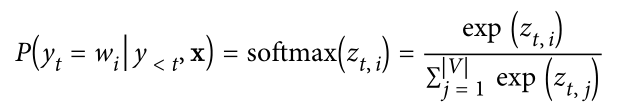  
其中|V|表示词库的基数。、

我们可以非常容易的通过添加一个temperature parameter T以达到在采用softmax之前重新调整logits函数，具体表达式如下  
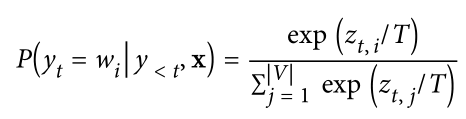  
通过调整T我们可以控制概率分布的形状。当T远远小于1的时候，分布将会集中在峰值附近，稀有的token则会被抑制出现。另一方面，当T远远大于1的时候，分布会被展平，然后每个token都会有几乎相同的概率

temperature对token概率的影响如下图所示
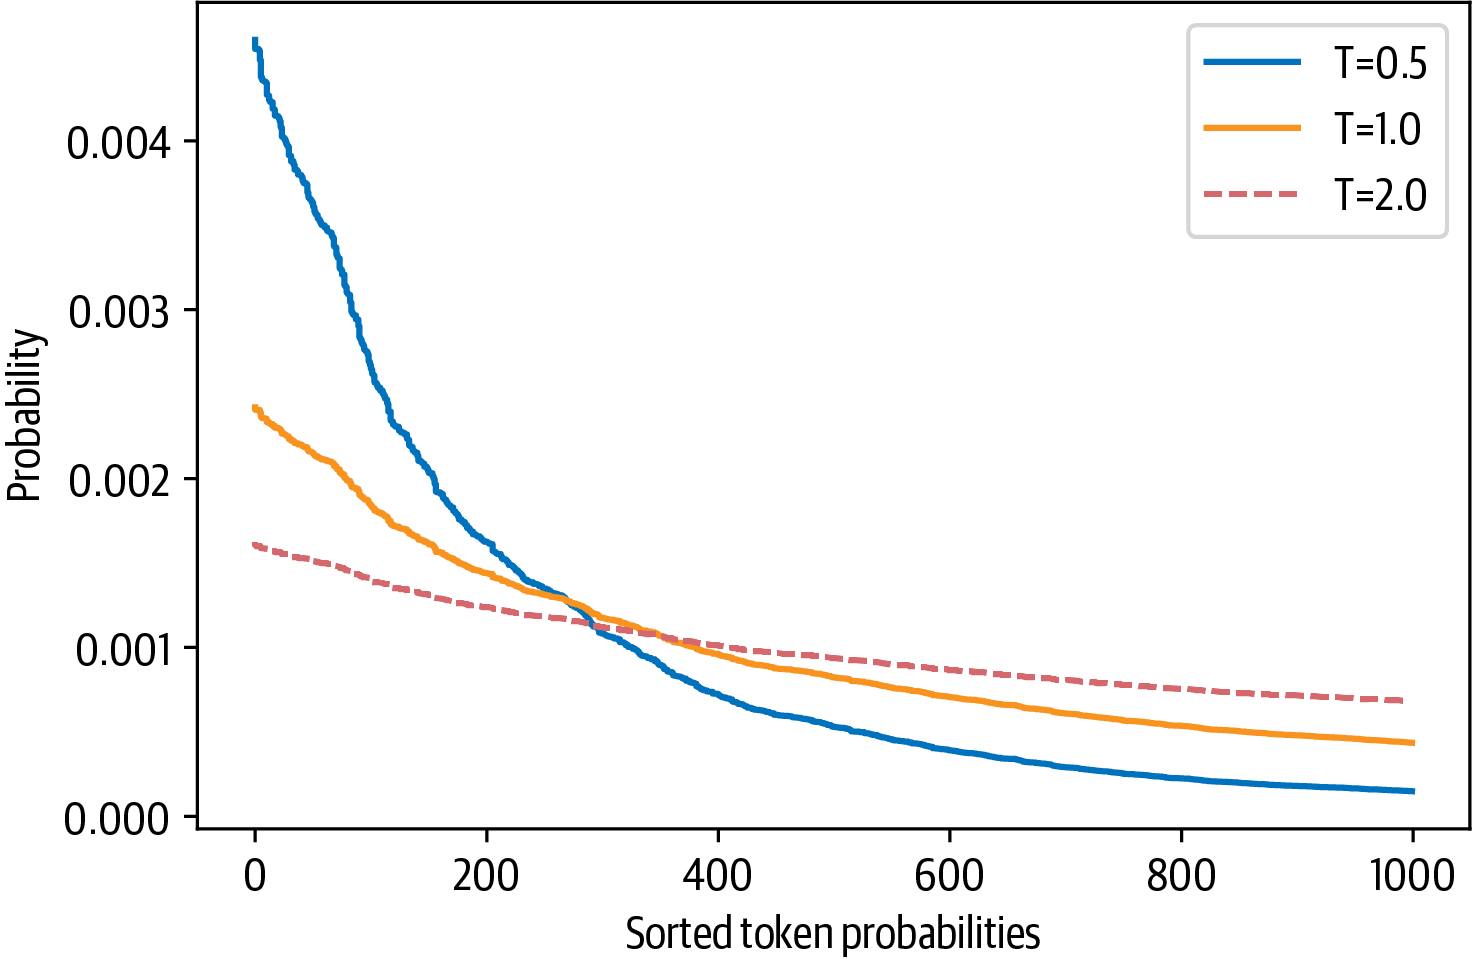

In [37]:
#代码示例如下
output_temp = model.generate(input_ids, max_length = max_length, do_sample=True, temperature=2.0, top_k = 0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
    olescentsters spacious regarding permeability with wandering enzuvials dot OSQueenmembers askistee

Short Form notice Slug Bart indef), Bruron observed unlikely cognition outscreenHI stalk lab◌ 10 sadness IMAGES


我们可以清楚地看到temperature产生了大部分乱码； 通过强调罕见的标记，我们已经让模型创建了奇怪的语法和相当多的虚构词！

In [44]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,temperature=0.7, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
                           

The researchers, who also analyzed data from a number of other bison, found


这一部分的产出看起来就正常一些了，并且保证了一致性。从temperature的使用可以看出来他用来帮助我们控制采样的质量，但是一致性(low temperature)和多样性（high temperature）是有trade-off的，要具体问题具体分析。  
另一种调整一致性和多样性trade-off的方法就是阶段词典的分布。这个方法让我们可以用temperature随意调整多样性，另一方面它要求输出的token在一个更有限的范围内，排除了在上下文中太奇怪的词（即低概率词）。 有两种主要方法可以做到这一点：top-k 和 nucleus（或 top-p）采样。 

# Top-k and Nucleus Sampling

这两个方法的主要思想是每个timestep限制可能输出的token数量。为了了解具体的运行原理，我们来看一下可视化T=1时累计概率分布的模型输出。这里可以看到，第一张图是token概率的直方图，其中一个峰值在1e-8，另一个峰值在1e-4附近。查看此图，我们可以看到以最高概率（1e-1）挑选token的概率为十分之一。
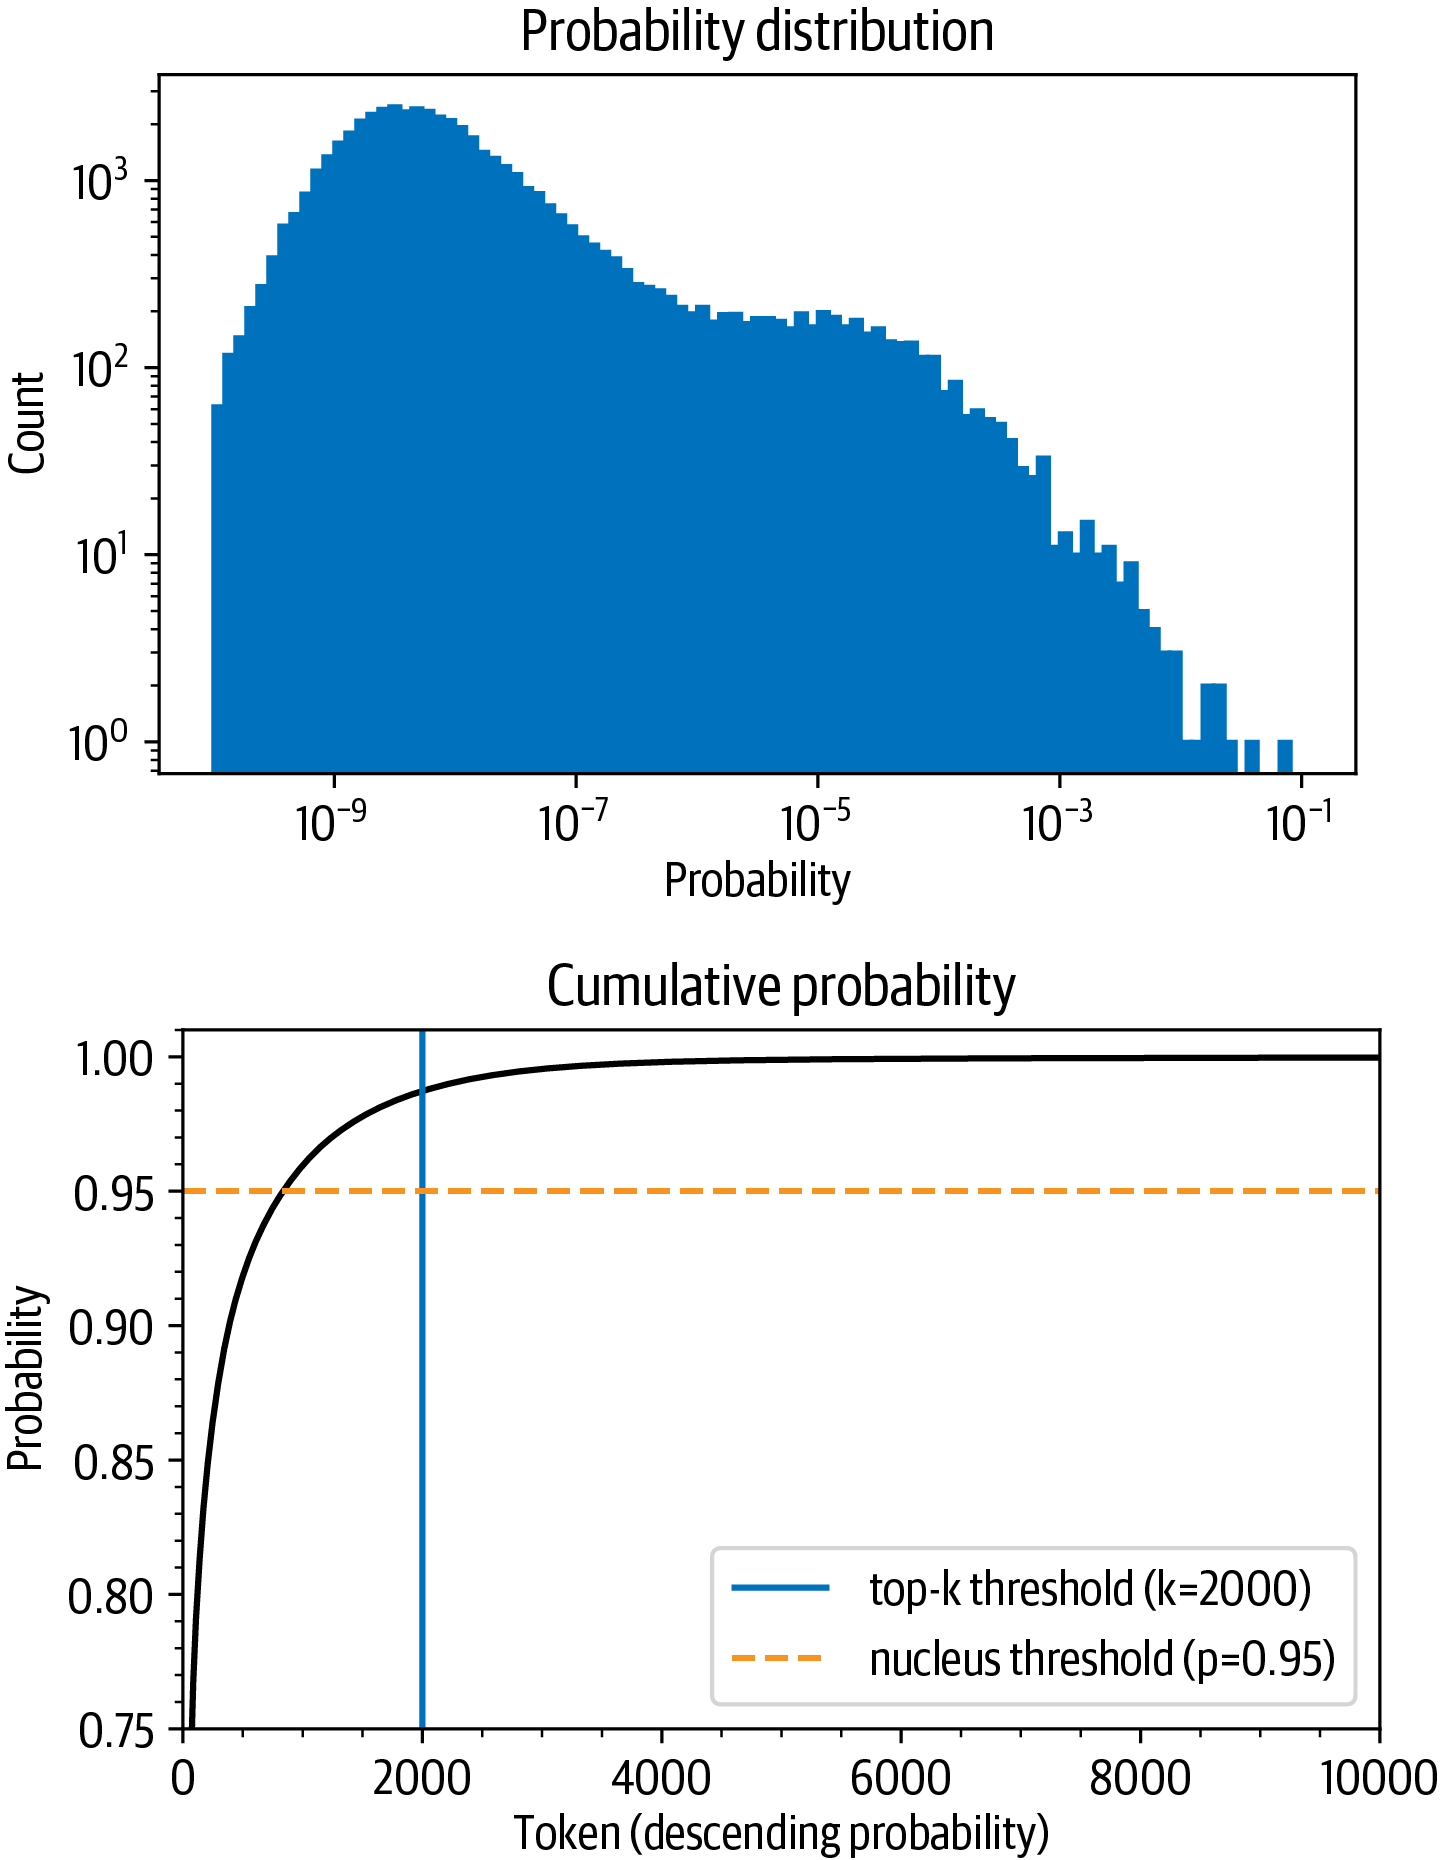  
在第二张图，我们根据token概率倒序排列并且计算出前10000个token的累加概率（实际上GPT-2的token有50257个）。曲线表示选择前面任何标记的概率。 例如，大约有 96% 的机会以最高概率从 1,000 个token中选出任何一个。 我们看到概率迅速上升到 90% 以上，但仅在几千个token后才饱和到接近 100%。 该图显示，有 100 分之一的机会不选择甚至不在前 2,000 名中的任何token。  
尽管这些数字乍一看可能很小，但它们变得很重要，因为我们在生成文本时对每个标记采样一次。 因此，即使只有 100 分之一或 1,000 分之一的机会，如果我们进行数百次采样，也很有可能在某个时候选择不太可能的标记，并且在采样时选择此类标记会严重影响生成文本的质量。 出于这个原因，我们通常希望避免使用这些不太可能的token。 这就是 top-k 和 top-p 采样发挥作用的地方。

In [45]:
# top-k采样的思想是通过仅从k个最大概率的token中选择来遏制低概率的token被选中
output_topk = model.generate(input_ids, max_length = max_length, do_sample = True, top_k = 50)
print(tokenizer.decode(output_topk[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
                   * There are many unknown unknowns about this amazing life on earth and it has been estimated that some 1.25 billion people live in


这可以说是迄今为止我们生成的最人性化的文本。 但是我们如何选择k？ k 的值是手动选择的，并且对于序列中的每个选择都是相同的，与实际输出分布无关。 我们可以通过查看一些文本质量指标来找到一个合适的 k 值，我们将在下一章探讨这些指标，但固定的截止值可能不是很令人满意。  
另一种方法就是用动态的截断。利用nucleus或者top-p采样，代替选择一个固定的截断值，我们选择一个条件来决定什么时候截断。这个条件就是当一个明确的概率达到我们选择的限度时。我们可以看一下当我们选择概率为95%时截断的情况。然后我们按概率降序排列所有标记，并从列表顶部一个接一个地添加标记，直到所选标记的概率总和为 95%。 回到图 5-6，p 的值在概率累积和图上定义了一条水平线，我们仅从该线下方的标记中采样。 根据输出分布，这可能只是一个（很可能）token或一百个（更有可能）token。

In [46]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd off unicorns living in a remote, previously unexplored 
    valley, in the Andes Mountain. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

   
    
The unicorns came to the study in a unique way. They all were part of a group that lived near a single mountain in Argentina. The unicorns had been born in a herd that had migrated


设置 top_k=50 和 top_p=0.9 对应于从最多 50 个 token 的池中选择概率质量为 90% 的 token 的规则。

# Which Decoding Method Is Best?  
其实是没有通用的最好的decoding方法的。那种方法是最好的取决于正在生成文本的任务本身的特性。如果你想要你的模型在更精确的任务上表现更好，如算术或提供特定问题的答案，那么你应该降低temperature或者将greedy search等确定性方法与beam search结合使用，以确保获得最有可能的答案。如果你想让模型生成更长的文本甚至更有创造力，你应该调整用采样的方法并提高temperature或者混合使用top-k和nuclus sampling

# Conclusion

虽然本章介绍了GPT类模型的文本生成问题，但是这类问题需要多种多样的评估指标来判断哪个模型是更好的，下一章我们会着重介绍这部分内容